## Part 1: The ReAct Framework

### What is ReAct?

**ReAct** stands for **Reasoning + Acting**. It's a prompting paradigm that enables LLMs to solve tasks by interleaving:

1. **Reasoning** - Thinking about what to do next
2. **Acting** - Taking actions (calling tools)
3. **Observing** - Processing action results

```
┌─────────────────────────────────────────────────────────┐
│                    ReAct Loop                           │
├─────────────────────────────────────────────────────────┤
│                                                         │
│   THOUGHT: "I need to find the weather in Tokyo.        │
│            I should use the weather tool."              │
│                    │                                    │
│                    ▼                                    │
│   ACTION: get_weather(city="Tokyo")                     │
│                    │                                    │
│                    ▼                                    │
│   OBSERVATION: "Tokyo: 28°C, humid"                     │
│                    │                                    │
│                    ▼                                    │
│   THOUGHT: "I have the weather info. Now I can          │
│            provide the answer to the user."             │
│                    │                                    │
│                    ▼                                    │
│   FINAL ANSWER: "The weather in Tokyo is 28°C..."       │
│                                                         │
└─────────────────────────────────────────────────────────┘
```

### Why ReAct Works

The key insight: **Making the LLM "think out loud" before acting improves decision quality**.

- Explicit reasoning reduces errors
- Observations ground the agent in reality
- The loop allows self-correction

### ReAct vs. Chain-of-Thought

You might have heard of **Chain-of-Thought (CoT)** prompting. How does ReAct differ?

```
CHAIN-OF-THOUGHT (CoT)
══════════════════════
Q: What's 23 × 17?

Let me think step by step:
- 23 × 17 = 23 × (10 + 7)
- = 230 + 161
- = 391

✓ Internal reasoning only
✓ No external actions
✓ Static knowledge
```

```
ReAct
═════
Q: What's the weather in Tokyo?

THOUGHT: I need to check real-time weather.
ACTION: get_weather("Tokyo")
OBSERVATION: 28°C, humid
THOUGHT: I have the answer.
ANSWER: It's 28°C in Tokyo...

✓ Reasoning + Actions
✓ External tool calls
✓ Dynamic information
```

| Aspect | Chain-of-Thought | ReAct |
|--------|------------------|-------|
| **Approach** | Pure reasoning | Reasoning + Acting |
| **External Tools** | ❌ No | ✅ Yes |
| **Real-time Data** | ❌ No | ✅ Yes |
| **Self-Correction** | Limited | Strong (via observations) |
| **Best For** | Math, logic puzzles | Tasks needing external info |

---

## Part 2: Setup & First ReAct Agent

In [40]:
# Setup environment
%run ../setup_llm.py


🚀 DIAL Setup Utility Test

🔍 Checking DIAL Configuration...
✅ DIAL_API_KEY is set
✅ AZURE_OPENAI_ENDPOINT is set
✅ AZURE_OPENAI_API_VERSION is set

📋 Optional settings:
   AZURE_OPENAI_DEPLOYMENT_NAME: gpt-4
   AZURE_OPENAI_MODEL_NAME: gpt-4

✅ DIAL setup verified successfully!

📝 Testing model initialization...
✅ Model created: gpt-4
✅ Test response: HelloDIAL!


In [41]:
import sys
sys.path.insert(0, '..')  # Add parent directory to path for setup_llm

from setup_llm import get_chat_model  # Use LLM helper
from langchain_core.tools import tool
from langchain.agents import create_agent  # LangChain v1.0 - new standard for building agents
import os

# Initialize model
# init_chat_model provides a unified interface for all chat model providers
# Initialize model using DIAL (Azure OpenAI)
model = get_chat_model(temperature=0)

print("✅ Environment ready")


✅ Environment ready


In [42]:
# Define tools for our ReAct agent
@tool
def get_weather(city: str) -> str:
    """
    Get the current weather for a city.
    
    Args:
        city: The name of the city
    Returns:
        Weather information for the city
    """
    weather_data = {
        "paris": "22°C, sunny",
        "london": "15°C, rainy",
        "tokyo": "28°C, humid",
        "new york": "18°C, clear",
        "singapore": "32°C, partly cloudy"
    }
    return weather_data.get(city.lower(), f"Weather data not available for {city}")

@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression.
    
    Args:
        expression: A mathematical expression (e.g., '2 + 3 * 4')
    Returns:
        The result of the calculation
    """
    try:
        # Safe evaluation of math expressions
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error: {str(e)}"

print("✅ Tools defined: get_weather, calculator")

✅ Tools defined: get_weather, calculator


In [43]:
# Create a ReAct agent using create_agent (LangChain v1.0)
react_agent = create_agent(
    model=model,
    tools=[get_weather, calculator]
)

print("✅ ReAct agent created with 2 tools")

✅ ReAct agent created with 2 tools


### See ReAct in Action

In [44]:
# Test the ReAct agent with a multi-step question
response = react_agent.invoke({
    "messages": [("user", "What's the temperature in Tokyo and Paris? What's the difference?")]
})

# Trace the ReAct loop
print("🔄 ReAct Loop Trace:")
print("=" * 60)

for i, msg in enumerate(response["messages"], 1):
    role = msg.type.upper()
    
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print(f"\n{i}. [ACTION] 🔧 Tool Calls:")
        for call in msg.tool_calls:
            print(f"      → {call['name']}({call['args']})")
    elif role == "TOOL":
        print(f"\n{i}. [OBSERVATION] 👁️ {msg.content}")
    elif hasattr(msg, 'content') and msg.content:
        if role == "AI":
            print(f"\n{i}. [THOUGHT/ANSWER] 💭")
            print(f"      {msg.content[:200]}..." if len(msg.content) > 200 else f"      {msg.content}")
        else:
            print(f"\n{i}. [{role}] {msg.content[:100]}")

print("\n" + "=" * 60)

🔄 ReAct Loop Trace:

1. [HUMAN] What's the temperature in Tokyo and Paris? What's the difference?

2. [ACTION] 🔧 Tool Calls:
      → get_weather({'city': 'Tokyo'})
      → get_weather({'city': 'Paris'})

3. [OBSERVATION] 👁️ 28°C, humid

4. [OBSERVATION] 👁️ 22°C, sunny

5. [ACTION] 🔧 Tool Calls:
      → calculator({'expression': '28 - 22'})

6. [OBSERVATION] 👁️ 6

7. [THOUGHT/ANSWER] 💭
      The temperature in Tokyo is 28°C (humid), and in Paris, it is 22°C (sunny). The difference in temperature is 6°C.



---

## Part 3: LangGraph Foundations

The ReAct agent you just used is built on **LangGraph**. Let's understand how it works.

### What is LangGraph?

**LangGraph** is a framework for building stateful, multi-step LLM applications as **graphs**.

```
LangGraph Components
════════════════════

┌─────────────────────────────────────────┐
│              StateGraph                 │
├─────────────────────────────────────────┤
│                                         │
│   STATE: Data that flows through graph  │
│                                         │
│   NODES: Functions that transform state │
│                                         │
│   EDGES: Connections between nodes      │
│                                         │
└─────────────────────────────────────────┘
```

### Why Graphs?

Graphs give you:
- **Explicit control flow** - See exactly how your agent works
- **Cycles** - Enable loops
- **State persistence** - Save and resume conversations
- **Human-in-the-loop** - Pause for human approval

### State: The Heart of LangGraph

**State** is a typed dictionary that holds all data as it flows through the graph.

In [10]:
from typing import TypedDict, Annotated, Literal
import operator

# Simple state - just messages
class SimpleState(TypedDict):
    messages: list

# State with a reducer - messages accumulate instead of overwrite
class ConversationState(TypedDict):
    messages: Annotated[list, operator.add]  # Reducer: new messages are appended
    
print("State definitions:")
print("  SimpleState: {messages: list}")
print("  ConversationState: {messages: list (with add reducer)}")

State definitions:
  SimpleState: {messages: list}
  ConversationState: {messages: list (with add reducer)}


### Understanding Reducers

**Reducers** define how state values combine when updated.

```
WITHOUT Reducer:
state["messages"] = ["new"]  →  messages = ["new"] (overwrites!)

WITH operator.add Reducer:
state["messages"] = ["new"]  →  messages = ["old", "new"] (appends!)
```

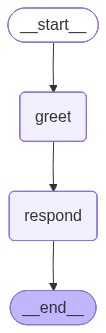

Messages accumulated via reducer:
  1. User starts chat
  2. Hello! Welcome to the chat.
  3. You've had 1 turns.

Final turn count: 2


In [45]:
# Demonstrate reducer behavior
from langgraph.graph import StateGraph, START, END

# State with accumulating messages
class ChatState(TypedDict):
    messages: Annotated[list, operator.add]
    turn_count: int

def greet_node(state: ChatState) -> dict:
    """First node adds a greeting"""
    return {
        "messages": ["Hello! Welcome to the chat."],
        "turn_count": state.get("turn_count", 0) + 1
    }

def respond_node(state: ChatState) -> dict:
    """Second node adds a response"""
    return {
        "messages": [f"You've had {state['turn_count']} turns."],
        "turn_count": state["turn_count"] + 1
    }

# Build a simple graph
builder = StateGraph(ChatState)
builder.add_node("greet", greet_node)
builder.add_node("respond", respond_node)

# Connect: START → greet → respond → END
builder.add_edge(START, "greet")
builder.add_edge("greet", "respond")
builder.add_edge("respond", END)

# Compile and run
demo_graph = builder.compile()

# Visualize our agent
from IPython.display import Image, display
try:
    display(Image(demo_graph.get_graph().draw_mermaid_png()))
except Exception:
    print(demo_graph.get_graph().draw_mermaid())


result = demo_graph.invoke({"messages": ["User starts chat"], "turn_count": 0})

print("Messages accumulated via reducer:")
for i, msg in enumerate(result["messages"], 1):
    print(f"  {i}. {msg}")
print(f"\nFinal turn count: {result['turn_count']}")

---

## Part 4: Building Graphs with Nodes and Edges

Let's build a more interesting graph with **conditional routing**.

In [46]:
from langgraph.graph import StateGraph, START, END

# State for our routing example
class RouterState(TypedDict):
    query: str
    category: str
    response: str

# Node functions
def classify_query(state: RouterState) -> dict:
    """Classify the query into a category"""
    query = state["query"].lower()
    
    if any(word in query for word in ["weather", "temperature", "rain", "sunny"]):
        category = "weather"
    elif any(word in query for word in ["calculate", "math", "sum", "+", "-", "*", "/"]):
        category = "math"
    else:
        category = "general"
    
    return {"category": category}

def handle_weather(state: RouterState) -> dict:
    """Handle weather queries"""
    return {"response": "🌤️ This is a weather query. In production, I'd call a weather API!"}

def handle_math(state: RouterState) -> dict:
    """Handle math queries"""
    return {"response": "🔢 This is a math query. In production, I'd calculate the result!"}

def handle_general(state: RouterState) -> dict:
    """Handle general queries"""
    return {"response": "💬 This is a general query. I'd use the LLM to respond!"}

print("✅ Node functions defined")

✅ Node functions defined


In [47]:
# Routing function - determines which edge to take
def route_query(state: RouterState) -> Literal["weather", "math", "general"]:
    """Route to the appropriate handler based on category"""
    return state["category"]

# Build the graph
builder = StateGraph(RouterState)

# Add nodes
builder.add_node("classify", classify_query)
builder.add_node("weather", handle_weather)
builder.add_node("math", handle_math)
builder.add_node("general", handle_general)

# Add edges
builder.add_edge(START, "classify")

# Conditional routing after classification
builder.add_conditional_edges(
    "classify",
    route_query,
    {
        "weather": "weather",
        "math": "math",
        "general": "general"
    }
)

# All handlers go to END
builder.add_edge("weather", END)
builder.add_edge("math", END)
builder.add_edge("general", END)

# Compile
router_graph = builder.compile()

print("✅ Router graph compiled")

# Visualize our agent
from IPython.display import Image, display
try:
    display(Image(router_graph.get_graph().draw_mermaid_png()))
except Exception:
    print(router_graph.get_graph().draw_mermaid())


✅ Router graph compiled
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	classify(classify)
	weather(weather)
	math(math)
	general(general)
	__end__([<p>__end__</p>]):::last
	__start__ --> classify;
	classify -.-> general;
	classify -.-> math;
	classify -.-> weather;
	general --> __end__;
	math --> __end__;
	weather --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [49]:
# Test the router
test_queries = [
    "What's the weather in Tokyo?",
    "Calculate 25 * 4",
    "Tell me a joke"
]

print("🔀 Router Graph Tests:")
print("=" * 50)

for query in test_queries:
    result = router_graph.invoke({"query": query, "category": "", "response": ""})
    print(f"\nQuery: {query}")
    print(f"Category: {result['category']}")
    print(f"Response: {result['response']}")

🔀 Router Graph Tests:

Query: What's the weather in Tokyo?
Category: weather
Response: 🌤️ This is a weather query. In production, I'd call a weather API!

Query: Calculate 25 * 4
Category: math
Response: 🔢 This is a math query. In production, I'd calculate the result!

Query: Tell me a joke
Category: general
Response: 💬 This is a general query. I'd use the LLM to respond!


### Visualize the Graph

LangGraph can generate a visual representation of your graph.

In [50]:
# Display the graph structure
# Visualize our agent
from IPython.display import Image, display
try:
    display(Image(router_graph.get_graph().draw_mermaid_png()))
except Exception:
    print(router_graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	classify(classify)
	weather(weather)
	math(math)
	general(general)
	__end__([<p>__end__</p>]):::last
	__start__ --> classify;
	classify -.-> general;
	classify -.-> math;
	classify -.-> weather;
	general --> __end__;
	math --> __end__;
	weather --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



---

## Part 5: Integrating Tools with LangGraph

Now let's build a proper agent graph that uses tools.

In [51]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode

# State for our agent
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

# Bind tools to the model
tools = [get_weather, calculator]
model_with_tools = model.bind_tools(tools)

# Node that calls the LLM
def call_model(state: AgentState) -> dict:
    """Call the LLM with the current messages"""
    response = model_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Create a ToolNode to execute tools
tool_node = ToolNode(tools)

# Routing function: should we call tools or end?
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Decide whether to call tools or end"""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, go to tools node
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    
    # Otherwise, we're done
    return "end"

print("✅ Agent components defined")

✅ Agent components defined


In [54]:
# Build the agent graph
agent_builder = StateGraph(AgentState)

# Add nodes
agent_builder.add_node("agent", call_model)
agent_builder.add_node("tools", tool_node)

# Add edges
agent_builder.add_edge(START, "agent")

# Conditional edge from agent
agent_builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

# Tools always go back to agent (the loop!)
agent_builder.add_edge("tools", "agent")

# Compile
custom_agent = agent_builder.compile()

print("✅ Custom ReAct agent compiled")
print("\nGraph structure:")
print("  START → agent ─┬─→ tools → agent (loop)")
print("                 └─→ END")

✅ Custom ReAct agent compiled

Graph structure:
  START → agent ─┬─→ tools → agent (loop)
                 └─→ END


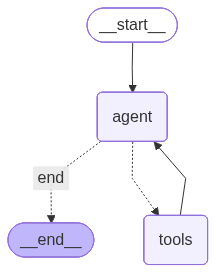

In [53]:
# Visualize our custom agent
try:
    display(Image(custom_agent.get_graph().draw_mermaid_png()))
except Exception:
    print(custom_agent.get_graph().draw_mermaid())

In [56]:
# Test our custom agent
result = custom_agent.invoke({
    "messages": [HumanMessage(content="What's the weather in Singapore and what's 100 + 50?")]
})

print("🤖 Custom Agent Response:")
print("=" * 50)

for msg in result["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"\n👤 User: {msg.content}")
    elif isinstance(msg, AIMessage):
        if msg.tool_calls:
            print(f"\n🔧 Tool Calls:")
            for call in msg.tool_calls:
                print(f"   → {call['name']}({call['args']})")
        elif msg.content:
            print(f"\n🤖 Assistant: {msg.content}")
    elif isinstance(msg, ToolMessage):
        print(f"\n📥 Tool Result: {msg.content}")

🤖 Custom Agent Response:

👤 User: What's the weather in Singapore and what's 100 + 50?

🔧 Tool Calls:
   → get_weather({'city': 'Singapore'})
   → calculator({'expression': '100 + 50'})

📥 Tool Result: 32°C, partly cloudy

📥 Tool Result: 150

🤖 Assistant: The weather in Singapore is 32°C and partly cloudy. Also, 100 + 50 equals 150.


---

## Part 6: Streaming Responses

For a better user experience, we can **stream** responses as they're generated.

In [57]:
# Stream agent execution
print("🔄 Streaming agent execution:")
print("=" * 50)

for event in custom_agent.stream(
    {"messages": [HumanMessage(content="What's 25 * 4 and what's the weather in Paris?")]}
):
    for node_name, node_output in event.items():
        print(f"\n📍 Node: {node_name}")
        
        if "messages" in node_output:
            for msg in node_output["messages"]:
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    for call in msg.tool_calls:
                        print(f"   🔧 {call['name']}({call['args']})")
                elif hasattr(msg, "content") and msg.content:
                    content = msg.content[:150] + "..." if len(msg.content) > 150 else msg.content
                    print(f"   💬 {content}")

🔄 Streaming agent execution:

📍 Node: agent
   🔧 calculator({'expression': '25 * 4'})
   🔧 get_weather({'city': 'Paris'})

📍 Node: tools
   💬 100
   💬 22°C, sunny

📍 Node: agent
   💬 The result of 25 * 4 is 100.  
The weather in Paris is 22°C and sunny.


---

## Part 7: Advanced Tool Patterns

Now let's explore more sophisticated tool patterns that you'll use in production.


### Example 2: Tool with Multiple Parameters

In [58]:
from typing import Annotated

@tool
def book_flight(
    origin: Annotated[str, "The departure city"],
    destination: Annotated[str, "The destination city"],
    date: Annotated[str, "Travel date in YYYY-MM-DD format"]
) -> str:
    """Book a flight between two cities."""
    return f"Flight booked: {origin} → {destination} on {date}. Confirmation: FL{hash(f'{origin}{destination}{date}') % 10000}"

# Agent understands these Annotated hints!
print(f"✅ Flight booking tool created")
print(f"   Parameters: origin, destination, date")
print(f"\nTest: {book_flight.invoke({'origin': 'Singapore', 'destination': 'Melbourne', 'date': '2025-03-15'})}")

✅ Flight booking tool created
   Parameters: origin, destination, date

Test: Flight booked: Singapore → Melbourne on 2025-03-15. Confirmation: FL6508


### Example 3: Structured Output with Pydantic

**Why Pydantic?**
- Type-safe data validation
- Automatic JSON schema generation
- Forces LLM to return structured data

**Use Cases:**
- Planning agents (subtasks list)
- Data extraction (structured info from text)
- Multi-agent coordination (task assignments)

In [59]:
from pydantic import BaseModel, Field
from typing import List
from enum import Enum

class TripType(str, Enum):
    BUSINESS = "business"
    LEISURE = "leisure"
    FAMILY = "family"

class TravelPreferences(BaseModel):
    """User travel preferences for booking."""
    trip_type: TripType = Field(description="Type of trip")
    budget: str = Field(description="Budget category: low, medium, high")
    interests: List[str] = Field(description="List of interests (e.g., museums, food, beaches)")
    duration_days: int = Field(description="Trip duration in days")

# Example: Force agent to return structured data
sample = TravelPreferences(
    trip_type=TripType.FAMILY,
    budget="medium",
    interests=["museums", "family-friendly activities"],
    duration_days=5
)

print("✅ Pydantic model defined")
print(f"\nSample JSON output:")
print(sample.model_dump_json(indent=2))

✅ Pydantic model defined

Sample JSON output:
{
  "trip_type": "family",
  "budget": "medium",
  "interests": [
    "museums",
    "family-friendly activities"
  ],
  "duration_days": 5
}


### Example 4: Agent with Parallel Tool Execution

**Parallel Execution** = Agent calls multiple tools simultaneously instead of sequentially.

**When LLM uses parallel execution:**
- Multiple independent tasks (weather for 3 cities)
- No dependencies between tool calls
- Significantly faster than sequential

In [60]:
@tool
def get_hotel_availability(city: str) -> str:
    """Check hotel availability in a city."""
    hotels = {
        "paris": "5 hotels available",
        "london": "3 hotels available",
        "tokyo": "8 hotels available"
    }
    return hotels.get(city.lower(), "No hotels found")

@tool
def get_flight_price(route: str) -> str:
    """Get flight price for a route (format: 'ORIGIN-DESTINATION')."""
    prices = {
        "singapore-melbourne": "$450",
        "london-paris": "$120",
        "new york-tokyo": "$800"
    }
    return prices.get(route.lower(), "Price not available")

# Create agent with multiple tools
travel_agent = create_agent(
    model=model,
    tools=[get_weather, get_hotel_availability, get_flight_price]
)

print("✅ Travel agent created with 3 tools")
print("   Tools: get_weather, get_hotel_availability, get_flight_price")

✅ Travel agent created with 3 tools
   Tools: get_weather, get_hotel_availability, get_flight_price


In [61]:
# Test parallel execution
response = travel_agent.invoke({
    "messages": [("user", "I need info for a Paris trip: weather, hotels, and flight from London")]
})

print("🔍 Agent Tool Calls:")
for msg in response["messages"]:
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print(f"\n📞 Called {len(msg.tool_calls)} tools:")
        for call in msg.tool_calls:
            print(f"   - {call['name']}({call['args']})")
        print("   ⚡ Parallel execution!" if len(msg.tool_calls) > 1 else "   Sequential execution")

print(f"\n🤖 Final Response:\n{response['messages'][-1].content}")

🔍 Agent Tool Calls:

📞 Called 3 tools:
   - get_weather({'city': 'Paris'})
   - get_hotel_availability({'city': 'Paris'})
   - get_flight_price({'route': 'LONDON-PARIS'})
   ⚡ Parallel execution!

🤖 Final Response:
Here's the information for your trip to Paris:

- **Weather in Paris**: 22°C, sunny.
- **Hotel Availability**: 5 hotels are available.
- **Flight Price from London to Paris**: $120.


---

## 🎯 Key Takeaways

### ReAct Framework

| Concept | Description |
|---------|-------------|
| **ReAct** | Reasoning + Acting in an interleaved loop |
| **Thought** | LLM reasons about what to do |
| **Action** | LLM calls a tool |
| **Observation** | Tool result informs next thought |

### Advanced Tool Patterns

| Pattern | Use Case |
|---------|----------|
| **Annotated Types** | Clear parameter documentation for LLM |
| **Pydantic Models** | Structured output validation |
| **Parallel Execution** | Multiple independent tool calls |
| **Error Handling** | Graceful failure in production |

### LangGraph Foundations

| Component | Purpose |
|-----------|--------|
| **State** | Typed dict holding data that flows through graph |
| **Reducer** | Defines how state values combine (e.g., `operator.add`) |
| **Node** | Function that transforms state |
| **Edge** | Connection between nodes |
| **Conditional Edge** | Dynamic routing based on state |

### What's Next

In **Module 2**, we'll explore **Workflow Patterns & Planning**:
- Prompt chaining
- Routing patterns
- Parallelization
- Planning agents with task decomposition

---


## Practice Exercise

**Challenge**: Build a custom graph that:
1. Classifies user sentiment (positive/negative/neutral)
2. Routes to different response handlers
3. Returns an appropriate response

Hints:
- Use a simple keyword-based classifier (or use the LLM!)
- Create 3 handler nodes
- Use conditional routing

In [42]:
# Your solution here:

class SentimentState(TypedDict):
    message: str
    sentiment: str
    response: str

def classify_sentiment(state: SentimentState) -> dict:
    """Classify the sentiment of the message"""
    # TODO: Implement classification
    pass

def handle_positive(state: SentimentState) -> dict:
    return {"response": "😊 Great to hear that! How can I help you today?"}

def handle_negative(state: SentimentState) -> dict:
    return {"response": "😔 I'm sorry to hear that. How can I help make things better?"}

def handle_neutral(state: SentimentState) -> dict:
    return {"response": "📝 I understand. What would you like to do?"}

# TODO: Build the graph
# sentiment_graph = ...

print("💡 Implement your sentiment router above!")

💡 Implement your sentiment router above!
